<a href="https://colab.research.google.com/github/saspav/DA-104/blob/main/%D0%9F%D0%B0%D0%B2%D0%BB%D0%BE%D0%B2%D0%B0_%D0%A1%D0%92_EDA_tutortop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA - разведочный анализ данных с tutortop.ru

In [1]:
import os
from time import time
from datetime import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.options.display.max_columns = None

params = {
          'axes.titlesize': 15,   # Размер шрифта главной подписи
          'axes.labelsize': 14,   # Размер шрифта подписей осей
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'ytick.labelsize': 12,  # Размер шрифта подписей тикетов оси Y

          }

plt.rcParams.update(params)

__import__('warnings').filterwarnings("ignore")

In [2]:
df = pd.DataFrame()

path_file = r'D:\проект_стажировкa'
name_file = 'parsing_tutortop.csv'
file_csv = os.path.join(path_file, name_file)
if not os.access(file_csv, os.F_OK):
    path_file = ''
    file_csv = 'https://raw.githubusercontent.com/saspav/DA-104/main/dataset/parsing_tutortop.zip'
df = pd.read_csv(file_csv, sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8667 entries, 0 to 8666
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        8667 non-null   object 
 1   partition       8667 non-null   object 
 2   course_title    8667 non-null   object 
 3   course          8667 non-null   int64  
 4   date            8162 non-null   float64
 5   dlitelnost      8667 non-null   object 
 6   pd_price        8162 non-null   float64
 7   popularity      0 non-null      float64
 8   price           8162 non-null   float64
 9   rassrochka      8162 non-null   float64
 10  rating          8667 non-null   float64
 11  school          8667 non-null   object 
 12  school_reviews  8667 non-null   int64  
 13  discount        8667 non-null   int64  
 14  course_url      8667 non-null   object 
dtypes: float64(6), int64(3), object(6)
memory usage: 1015.8+ KB


### В датасете 8667 объектов.

In [4]:
# посмотрим сколько пропусков
df.isna().sum()

category             0
partition            0
course_title         0
course               0
date               505
dlitelnost           0
pd_price           505
popularity        8667
price              505
rassrochka         505
rating               0
school               0
school_reviews       0
discount             0
course_url           0
dtype: int64

In [5]:
df.head()

,category,partition,course_title,course,date,dlitelnost,pd_price,popularity,price,rassrochka,rating,school,school_reviews,discount,course_url
0,Программирование,Python-разработка,Профессия Разработчик на Python,1528,1.659560e+09,10,137956.0,NaN,137956.0,4955.0,4.8,Skypro,58,82774,/goto/?number=1528&term=37
1,Программирование,Python-разработка,Онлайн-курс Python-разработчик,2591,1.658956e+09,7,124800.0,NaN,124800.0,6242.0,4.7,Бруноям,49,74900,/goto/?number=2591&term=37
2,Программирование,Python-разработка,Курс «Python-разработчик»,432,1.659992e+09,12,300000.0,NaN,126000.0,15000.0,4.7,Яндекс Практикум,185,0,/goto/?number=432&term=37
3,Программирование,Python-разработка,Fullstack-разработчик на Python,1188,1.659042e+09,18.5,159000.0,NaN,159000.0,6625.0,4.8,Нетология,72,0,/goto/?number=1188&term=37
4,Программирование,Python-разработка,Профессия Python-разработчик,232,1.659128e+09,12,255000.0,NaN,182807.0,5897.0,4.6,Skillbox,138,0,/goto/?number=232&term=37


Очистка и преобразование данных

In [6]:
# почистим данные
df.drop(['popularity', 'pd_price'], axis=1, inplace=True)
# заполним пропуски нулями
df.fillna(0, inplace=True)
# преобразуем в целое число
for name_col in ('price', 'rassrochka'):
    df[name_col] = df[name_col].astype(int)
# приведение отсутствии рассрочки к одному виду
df.loc[df['rassrochka'] == 1, 'rassrochka'] = 0
# преобразование даты из unixtime формата в читаемую дату
df['date'] = df['date'].apply(lambda x: datetime.fromtimestamp(x).date())
# заполнение пропусков в датах на 01.09.2021
date_first = datetime(2021, 9, 1).date()
df.loc[df['date'] < date_first, 'date'] = date_first
# преобразование длительности курса в число
df['dlitelnost'] = df['dlitelnost'].str.replace(',', '.')
df['dlitelnost'] = pd.to_numeric(df['dlitelnost'])
# формирование полного url
df['course_url'] = df['course_url'].apply(lambda x: f'https://tutortop.ru{x}')
# переименование колонок
df.rename(columns={'course': 'course_id', 'date': 'date_begin'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8667 entries, 0 to 8666
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        8667 non-null   object 
 1   partition       8667 non-null   object 
 2   course_title    8667 non-null   object 
 3   course_id       8667 non-null   int64  
 4   date_begin      8667 non-null   object 
 5   dlitelnost      8667 non-null   float64
 6   price           8667 non-null   int64  
 7   rassrochka      8667 non-null   int64  
 8   rating          8667 non-null   float64
 9   school          8667 non-null   object 
 10  school_reviews  8667 non-null   int64  
 11  discount        8667 non-null   int64  
 12  course_url      8667 non-null   object 
dtypes: float64(2), int64(5), object(6)
memory usage: 880.4+ KB


In [8]:
data = df.copy(deep=True)
data.head()

,category,partition,course_title,course_id,date_begin,dlitelnost,price,rassrochka,rating,school,school_reviews,discount,course_url
0,Программирование,Python-разработка,Профессия Разработчик на Python,1528,2022-08-03,10.0,137956,4955,4.8,Skypro,58,82774,https://tutortop.ru/goto/?number=1528&term=37
1,Программирование,Python-разработка,Онлайн-курс Python-разработчик,2591,2022-07-27,7.0,124800,6242,4.7,Бруноям,49,74900,https://tutortop.ru/goto/?number=2591&term=37
2,Программирование,Python-разработка,Курс «Python-разработчик»,432,2022-08-08,12.0,126000,15000,4.7,Яндекс Практикум,185,0,https://tutortop.ru/goto/?number=432&term=37
3,Программирование,Python-разработка,Fullstack-разработчик на Python,1188,2022-07-28,18.5,159000,6625,4.8,Нетология,72,0,https://tutortop.ru/goto/?number=1188&term=37
4,Программирование,Python-разработка,Профессия Python-разработчик,232,2022-07-29,12.0,182807,5897,4.6,Skillbox,138,0,https://tutortop.ru/goto/?number=232&term=37


### Проведем неграфический анализ данных:  посмотрим на частоту встречаемости значений ТОП-20

In [9]:
# отфильтруем категорию курсов, которые не интересны заказчику и бесплатные курсы
out_categiry = ('Детям', 'Образ жизни', 'Создание контента')
df = data[(~data['category'].isin(out_categiry)) & (data['price'] > 0)].drop('course_url', axis=1)

In [10]:
df.sample(7)

,category,partition,course_title,course_id,date_begin,dlitelnost,price,rassrochka,rating,school,school_reviews,discount
3879,Программирование,Фреймворк Laravel,Laravel. Глубокое погружение,966,2022-07-28,1.0,11970,0,4.3,GeekBrains,172,0
4048,Маркетинг,Web-аналитика,Микрокурс по веб-аналитике (с обр.связью),3565,2022-07-28,0.0,14000,3500,4.5,ppc.world,11,0
926,Дизайн,Графический дизайн,Визуальное искусство,3894,2022-08-31,0.0,770000,21388,4.3,Среда обучения,37,0
245,Программирование,JavaScript-разработка,Курс React.js Разработка веб-приложений,3969,2022-07-27,1.5,28500,2375,4.5,LoftSchool,28,0
932,Дизайн,Графический дизайн,DESIGN IT 2.0. (Расширенный),5282,2022-07-28,0.0,45000,15000,4.3,Design IT,12,0
4970,Управление,MBA,MBA Эксперт: Управление компанией,733,2022-08-11,0.0,289900,28990,4.1,Руcская Школа Управления,35,0
4982,Управление,MBA,Start (General). MBA,4783,2022-08-15,18.0,199000,5792,4.3,Moscow Business School,15,0


In [11]:
show_columns = ['category', 'partition', 'school']
for name_col in show_columns:
    print(f'Признак: "{name_col}", количество уникальных значений {df[name_col].nunique()}')
    print(df[name_col].value_counts()[:20])
    print()

Признак: "category", количество уникальных значений 7
Управление           1109
Программирование      889
Дизайн                761
Аналитика             481
Маркетинг             377
Иностранные языки     376
Бизнес и финансы       21
Name: category, dtype: int64

Признак: "partition", количество уникальных значений 155
Управление бизнесом                      193
MBA                                      116
Юридические аспекты бизнеса              105
Бухгалтерия                               95
Управление образовательными проектами     83
Финансы для руководителей                 82
Графический дизайн                        74
Web-дизайн                                72
3D-моделирование                          70
Дизайн интерьеров                         68
HR и управление персоналом                67
Web-разработка                            64
Системное администрирование               64
Отрисовка иллюстраций                     59
Python-разработка                         59
Ja

In [12]:
# сократим длинные наименования "школ"
def rename_school(text):
    return (text
            .replace('Московский институт профессионального образования',
                     'Моск.институт проф.обр')
            .replace('Московский институт технологий и управления',
                     'Моск.инст.техн. и упр.')
            .replace('Московская Бизнес Академия', 
                     'Моск. Бизнес Академия')
            .replace('Компьютерная Академия TOP', 
                     'Компьют. Академия TOP'))

df['school'] = df['school'].map(rename_school)

In [13]:
pd.DataFrame(df.price.describe().round())

,price
count,4014.0
mean,72378.0
std,90770.0
min,100.0
25%,18346.0
50%,47000.0
75%,98000.0
max,1500000.0


#### Медианная стоимость курса равна 47 тысяч. Средняя стоимость 72 тысячи - это за счет наличия выбросов в большую сторону.
Посмотрим на курсы стоимостью более 300 тыс

In [14]:
df[df.price > 300000].sort_values('price')

,category,partition,course_title,course_id,date_begin,dlitelnost,price,rassrochka,rating,school,school_reviews,discount
207,Программирование,JavaScript-разработка,"Очный интенсив ""Full-stack разработчик. JavaSc...",5330,2022-08-07,3.0,305000,108000,4.3,Elbrus Coding Bootcamp,13,0
3686,Программирование,Верстка на HTML/CSS,"Очный интенсив ""Full-stack разработчик. JavaSc...",5330,2022-08-07,3.0,305000,108000,4.3,Elbrus Coding Bootcamp,13,0
4999,Управление,MBA,"Global Executive MBA: Стратегический менеджмент,",3813,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0
4995,Управление,MBA,Executive MBA ǀ 1 год,3819,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0
4991,Управление,MBA,"Executive MBA: Стратегический менеджмент, дипл...",3820,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0
3923,Программирование,Фреймворк ReactJS,"Очный интенсив ""Full-stack разработчик. JavaSc...",5330,2022-08-07,3.0,305000,108000,4.3,Elbrus Coding Bootcamp,13,0
3951,Программирование,Работа с GIT,"Очный интенсив ""Full-stack разработчик. JavaSc...",5330,2022-08-07,3.0,305000,108000,4.3,Elbrus Coding Bootcamp,13,0
596,Управление,Управление бизнесом,"Global Executive MBA: Стратегический менеджмент,",3813,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0
591,Управление,Управление бизнесом,Executive MBA ǀ 1 год,3819,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0
586,Управление,Управление бизнесом,"Executive MBA: Стратегический менеджмент, дипл...",3820,2022-07-30,0.0,305000,25416,4.3,EMAS,17,0


Некоторые курсы входят в разные разделы и разные категории, для дальнейшего анализа нужно избавиться от дубликатов и удалить курсы стоимостю более 420 тысяч, что бы отсечь дорогие директорские курсы для управления бизнесом.

In [15]:
df = df[df.price < 420000]

cnt = df['course_id'].value_counts()
course_idx = cnt[cnt > 1].index
course_idx

Int64Index([4847, 4850, 3702, 5632, 3692, 5340, 4846, 3691, 3685, 5555,
            ...
             722, 3942, 5451,  726, 2966, 5458,  328, 5129,  368,  972],
           dtype='int64', length=911)

911 курсов имеют дубли

In [16]:
dfp = df.drop(['category', 'partition'], axis=1).drop_duplicates('course_id')
pd.DataFrame(dfp.price.describe().round())

,price
count,2396.0
mean,60987.0
std,63067.0
min,100.0
25%,15000.0
50%,39000.0
75%,90356.0
max,408000.0


####  После удаления дубликатов и дорогих курсов медианная стоимость курса стала равна 39 тысяч. Средняя стоимость - 61 тысяча.

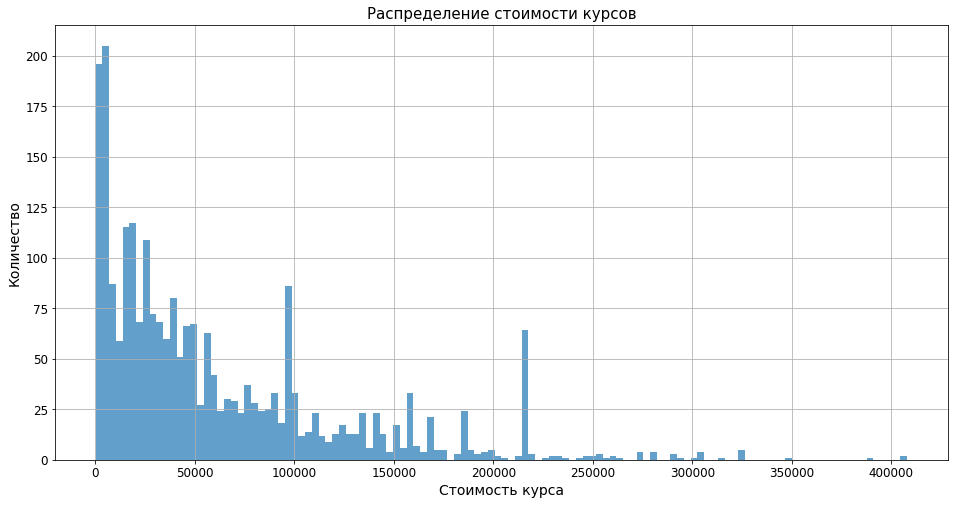

In [17]:
dfp['price'].hist(bins=120, figsize=(16, 8), alpha=0.7)
plt.ylabel('Количество')
plt.xlabel('Стоимость курса')
plt.title('Распределение стоимости курсов')
plt.show()

#### Посмотрим на стоимость курсов по другому

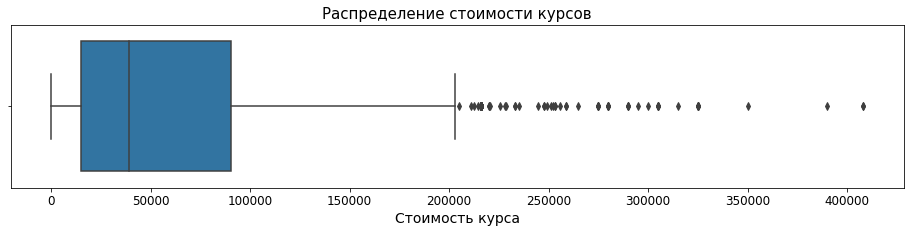

In [18]:
fig, ax = plt.subplots(figsize=(16, 3))
sns.boxplot(x='price', data=dfp, ax=ax)
plt.xlabel('Стоимость курса')
plt.title('Распределение стоимости курсов')
plt.show()

Посмотрим на распределение стоимости курсов по категориям

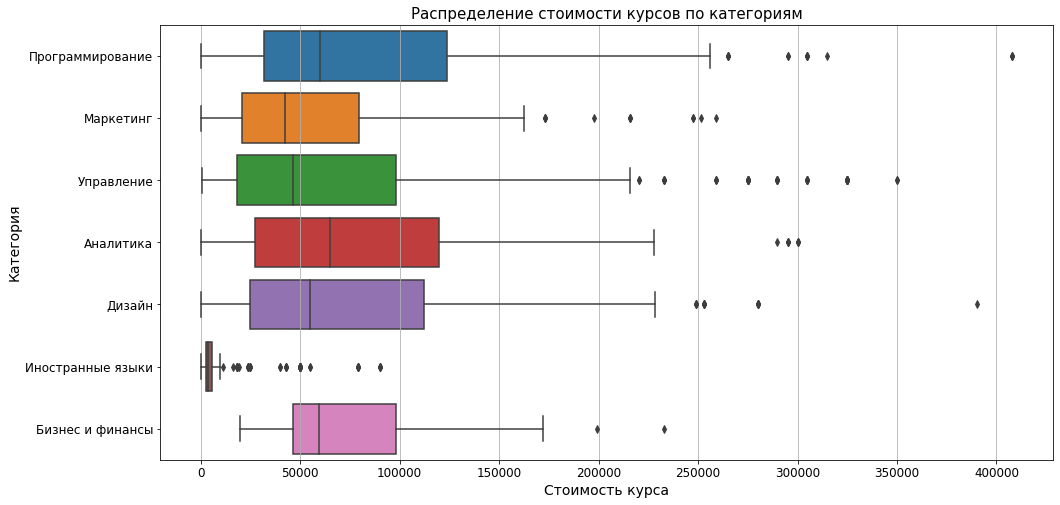

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(y='category', x='price', data=df, ax=ax)
plt.title('Распределение стоимости курсов по категориям')
plt.xlabel('Стоимость курса')
plt.ylabel('Категория')
plt.grid(axis='x')
plt.show()

Из этого графика видно, что мединная стоимость курсов в категориях Программирование, Аналитика, Дизайн, Бизнес и финансы одинаковая, Маркетинг и Управление поменьше и на последнем месте находятся Иностранные языки.

Проверим это на цифрах.

In [20]:
df.groupby('category', as_index=False).aggregate({'price': ['median', 'mean']}).round()

category    price         
                       median     mean
0          Аналитика  64800.0  79870.0
1   Бизнес и финансы  59400.0  80265.0
2             Дизайн  55000.0  72489.0
3  Иностранные языки   3600.0   9167.0
4          Маркетинг  42539.0  55108.0
5   Программирование  60000.0  80463.0
6         Управление  46463.0  72165.0

#### Проверим эти гипотезы статистическими методами.
По гистограмме видно, что распределение стоимости курсов далеко от нормального. 

Проверка нормальности по критерию Шапиро-Уилка. Нулевая гипотеза: стоимость курсов имеет нормальное распределение.

In [21]:
def check_result(p_value, feature=None):
    # задаем уровень значимости 5%
    alpha = 0.05
    if feature is not None:
        nf = f'Признак "{feature}": ' 
    else:
        nf = ''
    print(f'{nf}p-value = {p_value:.4f}')
    # сравниваем p-значение с заданным уровнем статистической значимости
    if results.pvalue < alpha:
        print(f'Отвергаем нулевую гипотезу')
    else:
        print(f'Принимаем нулевую гипотезу')
    print()


results = stats.shapiro(df['price'].dropna())
check_result(results.pvalue, 'Стоимость курсов')

Признак "Стоимость курсов": p-value = 0.0000
Отвергаем нулевую гипотезу



Данные имеют ненормальное распределение, для сравнения групп используем критерий Крускала-Уоллиса (у нас больше 2-х групп, данные ненормальные)

In [22]:
categories1 = ['Программирование', 'Аналитика', 'Дизайн', 'Бизнес и финансы']
results = stats.kruskal(*[df[df['category'] == category]['price'].dropna() for category in categories1])
check_result(results.pvalue)

p-value = 0.0148
Отвергаем нулевую гипотезу



Т.е. стоимость курсов в этих категориях статистически различается. Проверим категории: Маркетинг и Управление, т.к. у нас 2 группы используем критерий Манна-Уитни. В этих категориях стоимость курсов не различается.

In [23]:
categories2 = ['Маркетинг', 'Управление']
results = stats.mannwhitneyu(*[df[df['category'] == category]['price'].dropna() for category in categories2])
check_result(results.pvalue)

p-value = 0.1671
Принимаем нулевую гипотезу



#### Посмотрим на ключевых игроков на рынке курсов. 

In [24]:
def show_barh(dataset, column_name):
    show_counts = dataset[column_name].value_counts()[:13][::-1]
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.barh(show_counts.index, show_counts.values, alpha=0.7)
    plt.grid(axis='x')
    plt.title(f'Диаграмма распределения ТОП-13 авторов курсов')
    plt.xlabel('Количество курсов')
    plt.show()
    return show_counts

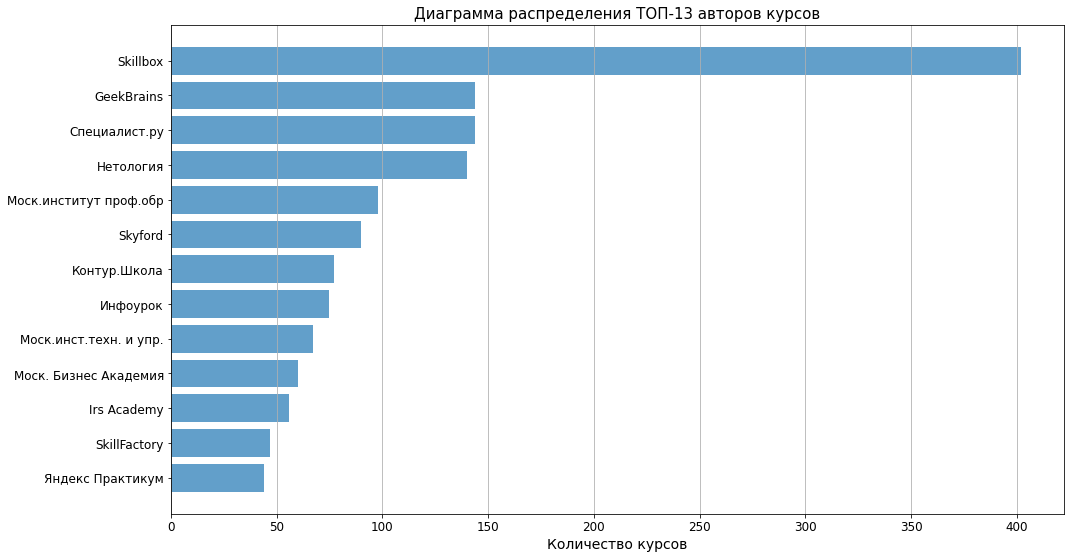

In [25]:
s_counts = show_barh(dfp, 'school')

Добавим к отобранным авторам курсов данные по рейтингу и количеству отзывов

In [26]:
counts = pd.DataFrame(s_counts[::-1])
counts = counts.rename_axis('index').reset_index()
counts.columns = ['school', 'counts']

rt = dfp[dfp.school.isin(counts.school)][['school', 'school_reviews', 'rating']].groupby(['school', 'rating'], 
                                                                                         as_index=False).school_reviews.max()
counts = counts.merge(rt, on='school', how='left')
# добавим коэффициент: отношение количества отзывов производителя к количеству курсов
counts['ratio'] = (counts['school_reviews'] / counts['counts']).round(1)
counts

,school,counts,rating,school_reviews,ratio
0,Skillbox,402,4.6,138,0.3
1,GeekBrains,144,4.3,173,1.2
2,Специалист.ру,144,4.3,23,0.2
3,Нетология,140,4.8,73,0.5
4,Моск.институт проф.обр,98,4.3,8,0.1
5,Skyford,90,4.3,27,0.3
6,Контур.Школа,77,4.5,57,0.7
7,Инфоурок,75,4.3,13,0.2
8,Моск.инст.техн. и упр.,67,4.3,7,0.1
9,Моск. Бизнес Академия,60,4.8,24,0.4


Сортировка по рейтингу

In [27]:
counts.sort_values(['rating', 'counts'], ascending=False)

,school,counts,rating,school_reviews,ratio
3,Нетология,140,4.8,73,0.5
9,Моск. Бизнес Академия,60,4.8,24,0.4
12,Яндекс Практикум,44,4.7,186,4.2
0,Skillbox,402,4.6,138,0.3
6,Контур.Школа,77,4.5,57,0.7
11,SkillFactory,47,4.5,229,4.9
1,GeekBrains,144,4.3,173,1.2
2,Специалист.ру,144,4.3,23,0.2
4,Моск.институт проф.обр,98,4.3,8,0.1
5,Skyford,90,4.3,27,0.3


Сортировка по количеству отзывов

In [28]:
counts.sort_values(['school_reviews', 'counts'], ascending=False)

,school,counts,rating,school_reviews,ratio
11,SkillFactory,47,4.5,229,4.9
12,Яндекс Практикум,44,4.7,186,4.2
1,GeekBrains,144,4.3,173,1.2
0,Skillbox,402,4.6,138,0.3
3,Нетология,140,4.8,73,0.5
6,Контур.Школа,77,4.5,57,0.7
10,Irs Academy,56,4.3,40,0.7
5,Skyford,90,4.3,27,0.3
9,Моск. Бизнес Академия,60,4.8,24,0.4
2,Специалист.ру,144,4.3,23,0.2


Сортировка по коэффициенту "ratio"

In [29]:
counts.sort_values(['ratio', 'rating'], ascending=False)

,school,counts,rating,school_reviews,ratio
11,SkillFactory,47,4.5,229,4.9
12,Яндекс Практикум,44,4.7,186,4.2
1,GeekBrains,144,4.3,173,1.2
6,Контур.Школа,77,4.5,57,0.7
10,Irs Academy,56,4.3,40,0.7
3,Нетология,140,4.8,73,0.5
9,Моск. Бизнес Академия,60,4.8,24,0.4
0,Skillbox,402,4.6,138,0.3
5,Skyford,90,4.3,27,0.3
2,Специалист.ру,144,4.3,23,0.2


#### Вот эти компании - основные игроки на рынке онлайн курсов.  На них будем ориентироваться.

In [30]:
dfs = df[df.school.isin(counts.school)]

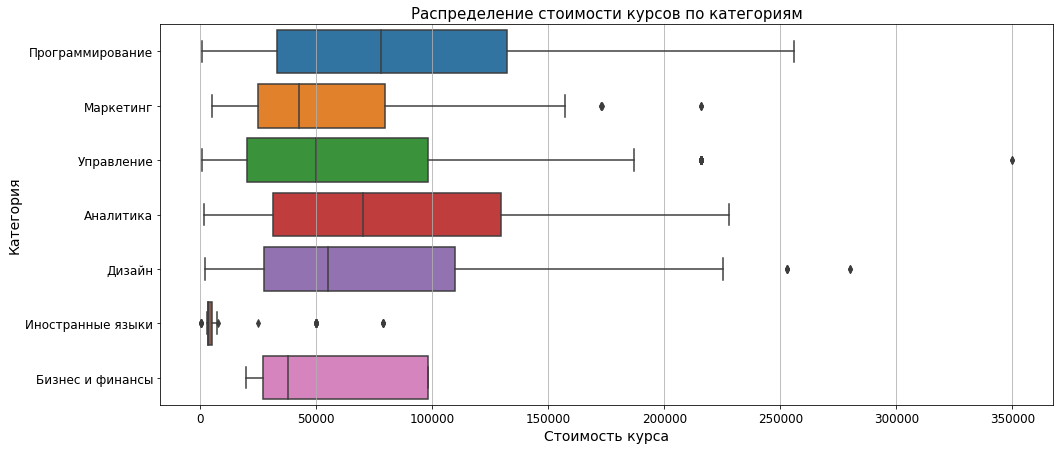

In [31]:
def show_boxplot_by_category(data):
    fig, ax = plt.subplots(figsize=(16, 7))
    sns.boxplot(y='category', x='price', data=data, ax=ax)
    plt.title('Распределение стоимости курсов по категориям')
    plt.xlabel('Стоимость курса')
    plt.ylabel('Категория')
    plt.grid(axis='x')
    plt.show()
    
show_boxplot_by_category(dfs)    

Для крупных игроков картина изменилась. Самые дорогие курсы стали по программированию и аналитике, т.е. самых ИТ-шных специальностей. Изменилась стоимость курсов в разных категориях. Проверим это статистикой:

In [32]:
# categories1 = ['Программирование', 'Аналитика', 'Дизайн', 'Бизнес и финансы']
results = stats.kruskal(*[dfs[dfs['category'] == category]['price'].dropna() for category in categories1])
check_result(results.pvalue)

p-value = 0.0143
Отвергаем нулевую гипотезу



In [33]:
# categories2 = ['Маркетинг', 'Управление']
results = stats.mannwhitneyu(*[dfs[dfs['category'] == category]['price'].dropna() for category in categories2])
check_result(results.pvalue)

p-value = 0.1438
Принимаем нулевую гипотезу



In [34]:
categories = ['Программирование', 'Аналитика']
results = stats.mannwhitneyu(*[dfs[dfs['category'] == category]['price'].dropna() for category in categories])
check_result(results.pvalue)

p-value = 0.7508
Принимаем нулевую гипотезу



In [35]:
categories = ['Дизайн', 'Бизнес и финансы']
results = stats.mannwhitneyu(*[dfs[dfs['category'] == category]['price'].dropna() for category in categories])
check_result(results.pvalue)

p-value = 0.3674
Принимаем нулевую гипотезу



На результаты проверки статистических гипотез можно посмотреть "глазами", чтобы увидеть примерное равенство / отличия средних и медиан в сравниваемых категориях.

In [36]:
dfs.groupby('category', as_index=False).aggregate({'price': ['median', 'mean']}).round()

category    price         
                       median     mean
0          Аналитика  70000.0  83996.0
1   Бизнес и финансы  38000.0  53867.0
2             Дизайн  55000.0  73814.0
3  Иностранные языки   3600.0   9719.0
4          Маркетинг  42539.0  55844.0
5   Программирование  78000.0  84757.0
6         Управление  49800.0  71268.0

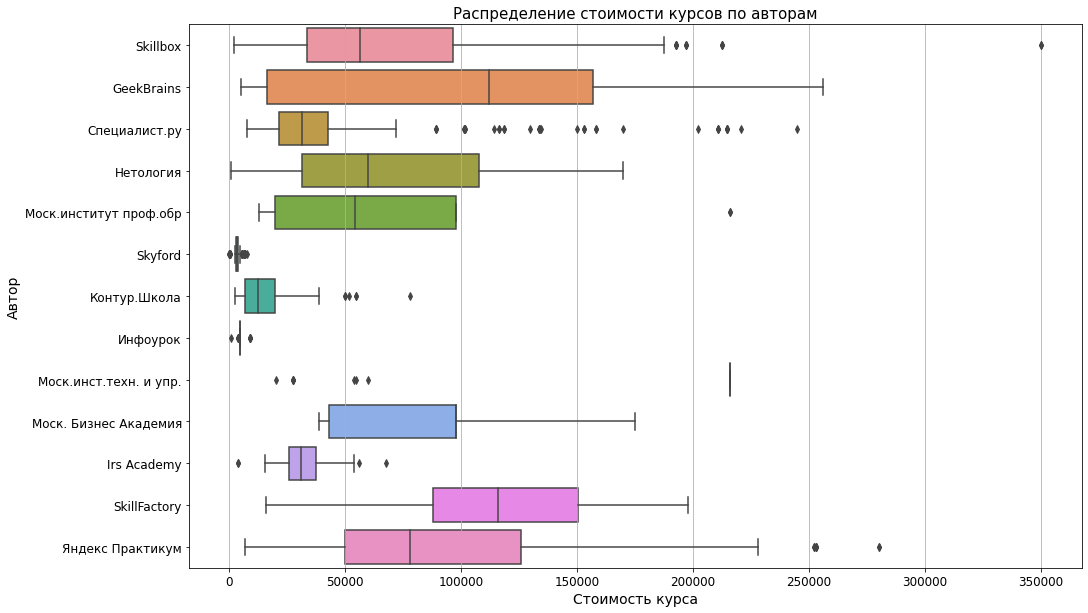

In [37]:
def show_boxplot_by_school(data):
    fig, ax = plt.subplots(figsize=(16,10))
    sns.boxplot(y='school', x='price', data=data, order=counts.school.values, ax=ax)
    plt.title('Распределение стоимости курсов по авторам')
    plt.xlabel('Стоимость курса')
    plt.ylabel('Автор')
    plt.grid(axis='x')
    plt.show()
    
show_boxplot_by_school(dfs)    

Посмотрим на стоимости курсов по категориям у разных авторов

Категория курсов: Программирование


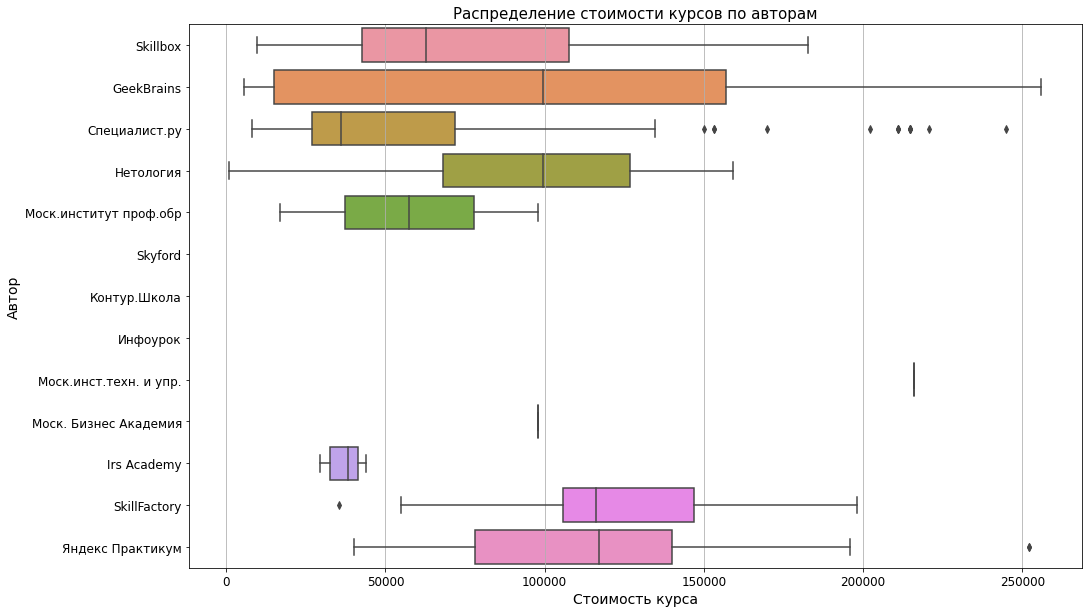

Категория курсов: Маркетинг


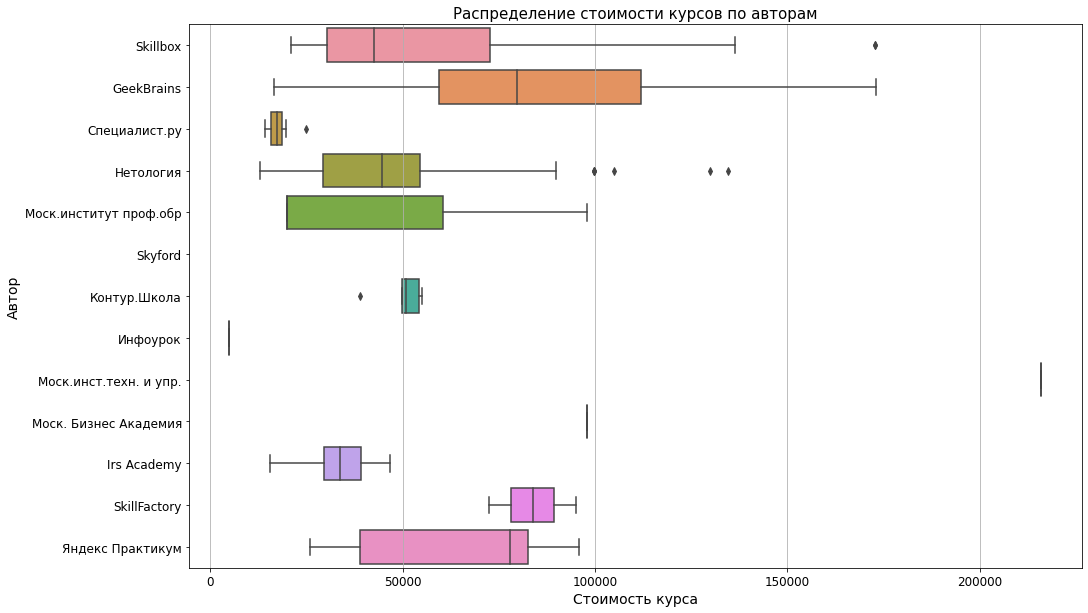

Категория курсов: Управление


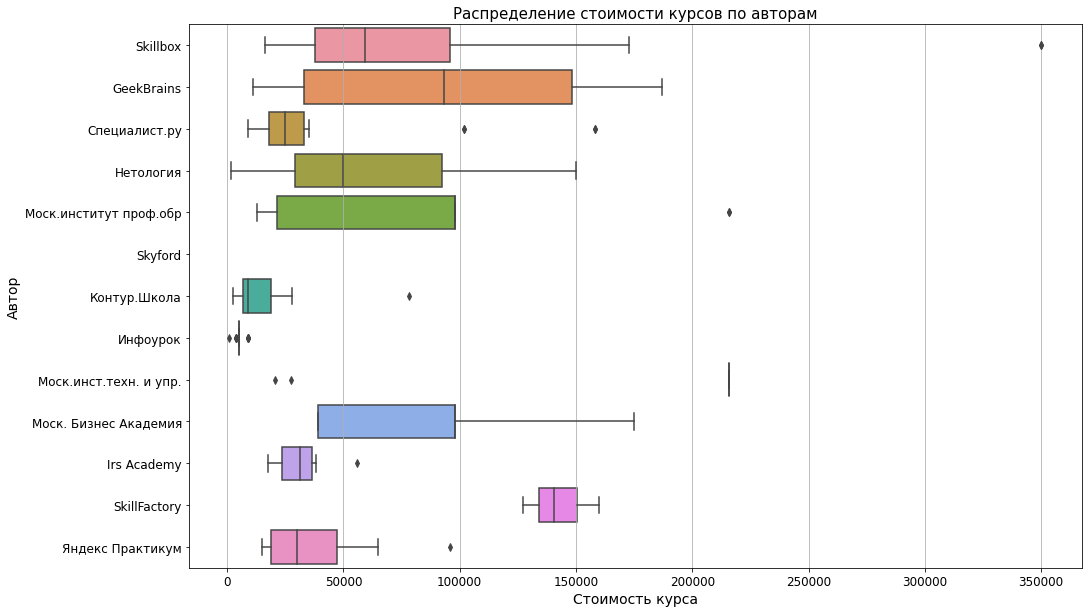

Категория курсов: Аналитика


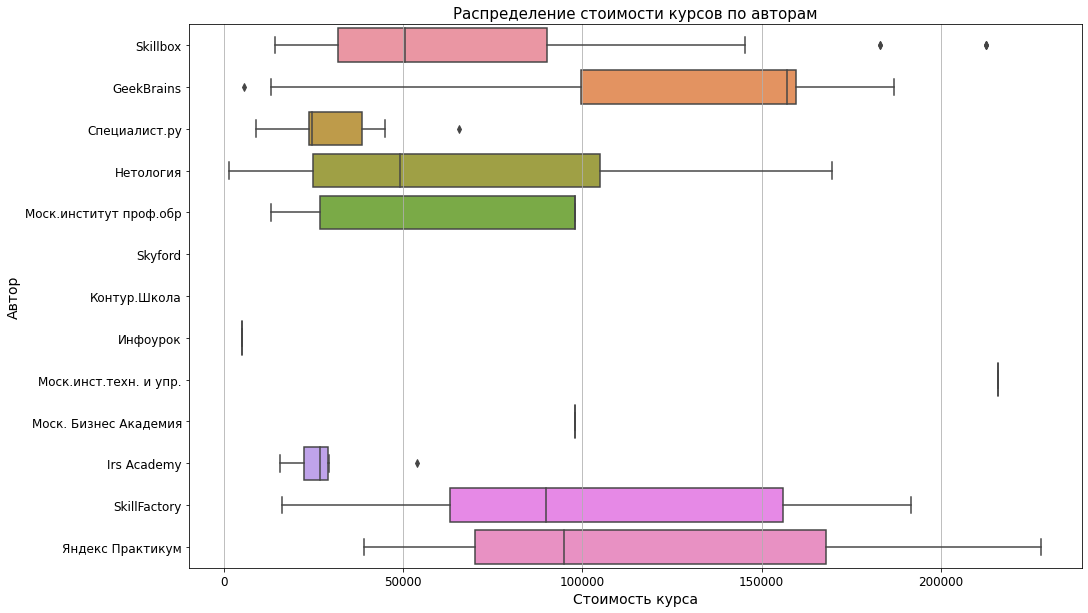

Категория курсов: Дизайн


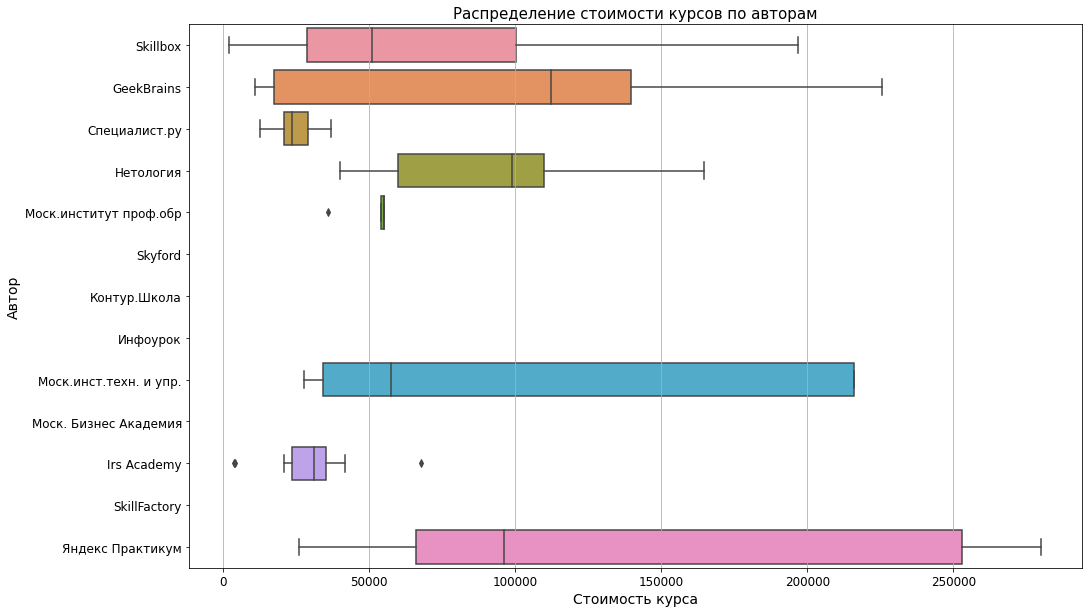

Категория курсов: Иностранные языки


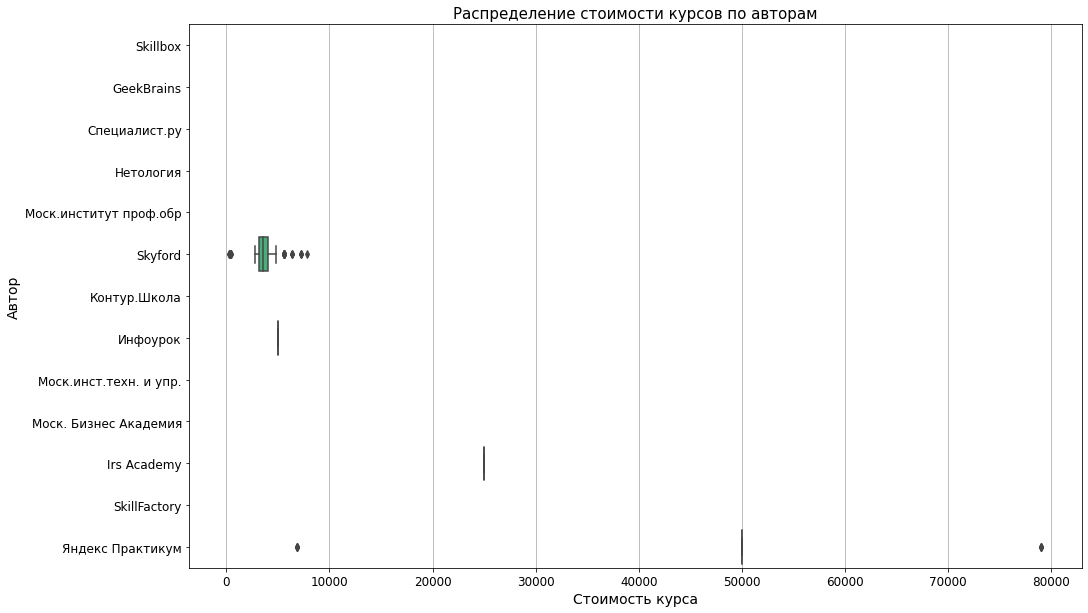

Категория курсов: Бизнес и финансы


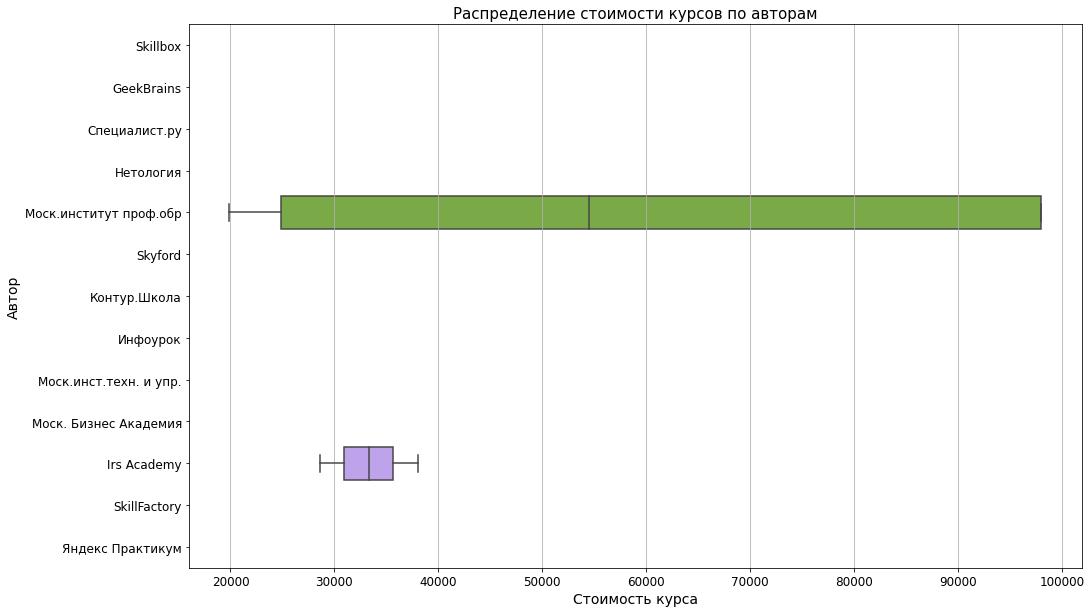

In [38]:
for category in dfs.category.unique():
    print(f'Категория курсов: {category}')
    show_boxplot_by_school(dfs[dfs.category == category])

У разных авторов стоимость курсов в одной категории имеет большой ценовой разброс.